In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
pd.options.plotting.backend = "plotly"
from scipy.stats import zscore
from scipy.signal import hilbert, butter, filtfilt, find_peaks
import pingouin as pg
import sys
from tqdm import tqdm
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


/Users/Oliver/miniconda3/envs/hippnac/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/Oliver/miniconda3/envs/hippnac/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Data loading

In [2]:
only_synced = False

dir = '/Users/Oliver/Google Drive/AG Remy/Petra/VTAtoMSDBopto'
syncDT = pd.read_excel('/Users/Oliver/Google Drive/AG Remy/Petra/VTAtoMSDBopto/sync.xlsx', header=None)
if only_synced:
    exps = [i.split('_sync.png')[0] for i in syncDT.loc[~syncDT[2].isnull(), 2].to_list()]
else:
    exps = [i.split('_sync.png')[0] for i in syncDT.loc[~syncDT[0].isnull(), 0].to_list()]
trial_type = 'OptoRew'
expselect = [i for i in exps if any(j in i for j in ['Opto2zones', 'rewOpto'])]

In [3]:
data = []

for exp in tqdm(expselect):
    data_exp = pd.read_hdf(os.path.join(dir, exp+'.h5'), 'behaviour')
    analogue_columns = ['sweep_index', 'position_raw', 'licking', 'pump', 'optotrigger',
       'camtrigger_raw', 'sweep', 'camtrigger', 'optobout', 'opto_freq',
       'position', 'velocity']

    # single experiment correction
    if exp=='20200124_#220_rewOpto_day4':
        data_exp.loc[data_exp.sweep==1, 'optotrigger'] = 0

    # velocity processing
    if data_exp.velocity.mean()>30:
        data_exp.velocity = data_exp.velocity / 2
    data_exp.loc[(data_exp.velocity>90)|(data_exp.velocity<-10), 'velocity'] = np.nan
    data_exp.velocity = data_exp.velocity.interpolate(method='linear')

    # licking processing
    LickingZeroed = data_exp.licking.values - np.mean(data_exp.licking.values)
    # Hilbert-Transform for Envelope:
    Analytic_signal = hilbert(LickingZeroed)
    Licking_Envelope = np.abs(Analytic_signal)
    # Low-Pass Butter filter:
    fc = 2  # Cut-off frequency of the filter
    SampFreq = 38
    w = fc / (SampFreq / 2)  # Normalize the frequency to SamplingFrequency
    b, a = butter(5, w, 'low')
    LickingEnvFilt = filtfilt(b, a, Licking_Envelope)
    LickingEnvFilt[0:int(1.5 * SampFreq)] = 0
    data_exp['LickingEnvFilt'] = zscore(LickingEnvFilt)

    data_exp['Date'] = exp.split('_')[0]
    data_exp['Mouse'] = exp.split('#')[1][:3]
    data_exp['Group'] = 'ChR' if exp.split('#')[1][:3] in ['212','219', '220','221','222','224'] else 'EYFP'
    data_exp['Trial'] = ''.join(exp.split('_')[2:])
    data_exp['Experiment'] = exp
    data_exp['Lap'] = (data_exp.position.diff()<-100).cumsum()
    data_exp['Time'] = np.linspace(start=0, stop=len(data_exp)/38, num=len(data_exp))
    data_exp['Time_ds'] = (data_exp.Time*10).astype(int)
    if data_exp.optotrigger.max() == 0.5:
        data_exp.optotrigger = data_exp.optotrigger * 2
    data_exp['optobout'] = data_exp.optotrigger.astype(int).rolling(35, center=True).max().fillna(0).astype(bool)
    if 'opto_freq' not in data_exp.columns:
        data_exp['opto_freq'] = round((((data_exp.optotrigger.diff()==1).astype(int).rolling(75).mean())/.012).fillna(0)/3)*3
        data_exp.loc[data_exp.opto_freq==0, 'opto_freq'] = np.nan
        data_exp['opto_freq'] = data_exp['opto_freq'].rolling(75, center=True).max()
    data_exp['Opto_extended'] = (data_exp.optobout.rolling(300, center=True).mean()>0).astype(int)

    # resting periods
    rest_idx_raw = data_exp.index[data_exp.velocity<2]
    rest_epochs = (pd.Series(rest_idx_raw).diff()!=1).astype(int).cumsum()
    data_exp.loc[rest_idx_raw, 'rest_epochs'] = rest_epochs.values
    rest_epoch_counts = rest_epochs.value_counts()
    long_rest_epochs = rest_epoch_counts.index[rest_epoch_counts > 150].to_list()
    data_exp['long_rest'] = 0
    data_exp.loc[data_exp.rest_epochs.isin(long_rest_epochs), 'long_rest'] = 1
    
    # locomotion periods
    data_exp['locomotion_epochs'] = np.nan
    loco_idx_raw = data_exp.index[data_exp.velocity>2]
    loco_epochs = (pd.Series(loco_idx_raw).diff()!=1).astype(int).cumsum()
    data_exp.loc[loco_idx_raw, 'locomotion_epochs'] = loco_epochs.values
    loco_epoch_counts = loco_epochs.value_counts()
    long_loco_epochs = loco_epoch_counts.index[loco_epoch_counts > 150].to_list()
    loco_epochs_after_rest = list((data_exp['locomotion_epochs'].shift(-75)*data_exp['long_rest']).unique()[:-1].astype(int))
    data_exp['long_locomotion'] = 0
    data_exp.loc[data_exp.locomotion_epochs.isin(list(set(long_loco_epochs) & set(loco_epochs_after_rest))), 'long_locomotion'] = 1
    
    # indeces
    idx = {}
    idx['onset_opto'] = data_exp.index[data_exp.optobout.astype(int).diff()==1].to_list()
    idx['onset_opto_loco'] = [i for i in idx['onset_opto'] if data_exp.loc[data_exp.iloc[i:i+1500].index, 'velocity'].max()>2]
    idx['onset_longloco'] = data_exp.index[data_exp.long_locomotion.astype(int).diff()==1].to_list()
    idx['onset_longloco_noopto'] = [i for i in idx['onset_longloco'] if i not in data_exp.index[data_exp['Opto_extended']==1].to_list()]
    # idx['optoonset_extended'] data_exp.index[data_exp['Optoonset_extended']==1].to_list()
    idx['opto_noloco'] = [i for i in idx['onset_opto'] if data_exp.velocity.iloc[i:i+750].mean()<2]

    # on/offset times into dataframe
    def onset_timing(behaviour_exp, onset_name, ffill_limit):
        behaviour_exp['onset_time'] = np.nan
        behaviour_exp.loc[(behaviour_exp[onset_name]==1), 'onset_time'] = behaviour_exp.loc[(behaviour_exp[onset_name]==1), 'Time_ds']
        behaviour_exp.onset_time = behaviour_exp.onset_time.fillna(method='ffill', limit=ffill_limit).fillna(method='bfill', limit=int(ffill_limit/6))
        behaviour_exp['onset_time'] = behaviour_exp.Time_ds - behaviour_exp.onset_time
        return behaviour_exp['onset_time']
    
    for key in idx.keys():
        data_exp[key] = 0
        data_exp.loc[idx[key], key] = 1
        if 'stride' in key:
            ffill_limit = int(1/data_exp.Time.diff().mean())
        else:
            ffill_limit = int(30/data_exp.Time.diff().mean())
        data_exp[key+'_time'] = onset_timing(data_exp, key, ffill_limit)
        data_exp[key+'_epoch'] = data_exp[key].cumsum().shift(int(ffill_limit/6))
    
    # for/backward fill opto_freq:
    data_exp['opto_freq_sharp'] = data_exp['opto_freq'].copy()
    data_exp.loc[data_exp.opto_freq_sharp.isnull(), 'opto_freq_sharp'] = 0
    ffill_limit = int(30/data_exp.Time.diff().mean())
    data_exp['opto_freq'] = data_exp['opto_freq'].fillna(method='ffill', limit=ffill_limit).fillna(method='bfill', limit=int(ffill_limit/6))
    
    data.append(data_exp)
data = pd.concat(data)

data['optobout'] = data['optobout'].fillna(0).astype(bool)

100%|██████████| 15/15 [00:00<00:00, 16.78it/s]


# Data prep

In [4]:
optolaps = data.groupby(['Experiment', 'Lap']).max()['optotrigger']
optolaps

Experiment                  Lap
20200124_#214_rewOpto_day4  0      0.0
                            1      0.0
                            2      0.0
                            3      0.0
                            4      0.0
                                  ... 
20200201_#221_rewOpto       60     1.0
                            61     1.0
                            62     1.0
                            63     1.0
                            64     1.0
Name: optotrigger, Length: 442, dtype: float64

In [5]:
data['PosBin'] = pd.cut(data['position'], 72, labels=False)
lapbinned = data.groupby(['Mouse', 'PosBin', 'Experiment', 'Lap']).mean()
lapbinned['Group'] = data.groupby(['Mouse', 'PosBin', 'Experiment', 'Lap']).max()['Group']
lapbinned = lapbinned.join(optolaps, rsuffix='_lapwise')
lapbinned = lapbinned.reset_index()
lapbinned

,Experiment,Lap,Mouse,PosBin,sweep_index,position_raw,licking,pump,lfp,optotrigger,...,onset_longloco_epoch,onset_longloco_noopto,onset_longloco_noopto_time,onset_longloco_noopto_epoch,opto_noloco,opto_noloco_time,opto_noloco_epoch,opto_freq_sharp,Group,optotrigger_lapwise
0,20200124_#214_rewOpto_day4,0,214,47,60.125000,1.481094,0.000469,-0.000937,0.030273,0.000000,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.000000,EYFP,0.0
1,20200124_#214_rewOpto_day4,0,214,48,162.000000,1.597812,0.000313,-0.000833,0.020104,0.000000,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.000000,EYFP,0.0
2,20200124_#214_rewOpto_day4,0,214,49,263.375000,1.721563,0.001133,-0.000781,0.055547,0.000000,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.000000,EYFP,0.0
3,20200124_#214_rewOpto_day4,0,214,50,364.000000,1.837292,0.000417,-0.000729,0.011042,0.000000,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.000000,EYFP,0.0
4,20200124_#214_rewOpto_day4,0,214,51,451.000000,1.949375,0.000417,-0.000729,0.050208,0.000000,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.000000,EYFP,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28014,20200201_#221_rewOpto,64,221,17,57722.217391,-2.306977,0.000462,0.046413,-0.588859,0.521739,...,8.0,0.0,NaN,1.0,0.0,NaN,0.0,55.000000,ChR,1.0
28015,20200201_#221_rewOpto,64,221,18,58412.600000,-2.199875,0.000422,0.046375,-0.365141,0.433333,...,8.0,0.0,NaN,1.0,0.0,NaN,0.0,55.000000,ChR,1.0
28016,20200201_#221_rewOpto,64,221,19,59115.937500,-2.054434,0.000436,0.046400,-0.005892,0.458333,...,8.0,0.0,NaN,1.0,0.0,NaN,0.0,55.000000,ChR,1.0
28017,20200201_#221_rewOpto,64,221,20,59676.000000,-1.933084,0.000378,0.046488,0.021036,0.473684,...,8.0,0.0,NaN,1.0,0.0,NaN,0.0,49.210526,ChR,1.0


In [6]:
posbinned = lapbinned.groupby(['Mouse', 'PosBin', 'Experiment', 'optotrigger_lapwise']).mean()
posbinned['Group'] = lapbinned.groupby(['Mouse', 'PosBin', 'Experiment', 'optotrigger_lapwise']).max()['Group']
posbinned = posbinned.reset_index()
posbinned

,Mouse,PosBin,Experiment,optotrigger_lapwise,Lap,sweep_index,position_raw,licking,pump,lfp,...,onset_longloco_time,onset_longloco_epoch,onset_longloco_noopto,onset_longloco_noopto_time,onset_longloco_noopto_epoch,opto_noloco,opto_noloco_time,opto_noloco_epoch,opto_freq_sharp,Group
0,212,0,20200125_#212_Opto2zones_day5,0.0,2.000000,46801.089744,-4.438147,0.000474,-0.000770,0.888162,...,140.698718,2.000000,0.000000,140.698718,2.000000,0.0,NaN,0.0,0.000000,ChR
1,212,0,20200125_#212_Opto2zones_day5,1.0,7.500000,29725.349081,-4.442567,0.000421,-0.000784,0.006799,...,114.300491,8.375000,0.000000,114.300491,7.500000,0.0,NaN,0.0,18.250000,ChR
2,212,0,20200201_#212_rewOpto,0.0,22.947368,32426.270768,-4.437027,0.000468,0.165168,0.468034,...,146.209199,5.315789,0.000000,146.209199,2.789474,0.0,NaN,0.0,0.000000,ChR
3,212,0,20200201_#212_rewOpto,1.0,33.057143,28644.406503,-4.436830,0.000485,0.034673,0.263408,...,102.108157,5.428571,0.000000,113.070707,2.857143,0.0,NaN,0.0,11.657143,ChR
4,212,1,20200125_#212_Opto2zones_day5,0.0,2.000000,47124.833333,-4.313144,0.001175,-0.000719,-0.796527,...,143.942308,2.000000,0.000000,143.942308,2.000000,0.0,NaN,0.0,0.000000,ChR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783,224,71,20200124_#224_rewOpto_2_day4,0.0,8.666667,17803.650000,4.444208,0.000651,-0.000719,2.919552,...,NaN,0.000000,0.000000,NaN,0.000000,0.0,NaN,0.0,26.000000,ChR
1784,224,71,20200124_#224_rewOpto_2_day4,1.0,15.100000,14314.391667,4.449422,0.000617,-0.000766,1.362451,...,NaN,0.000000,0.000000,NaN,0.000000,0.0,NaN,0.0,39.000000,ChR
1785,224,71,20200125_#224_Opto2zones_day5,1.0,20.300000,30897.892711,4.461169,0.000534,-0.000780,0.033626,...,102.505495,0.150000,0.000000,NaN,0.000000,0.0,NaN,0.0,50.000000,ChR
1786,224,71,20200127_#224_Opto2zones_day6,0.0,8.000000,30850.940776,4.453553,0.000587,-0.000807,0.031685,...,146.576653,8.545455,0.001684,170.430460,6.363636,0.0,NaN,0.0,0.000000,ChR


# Zone 1 (Fig. S4B)

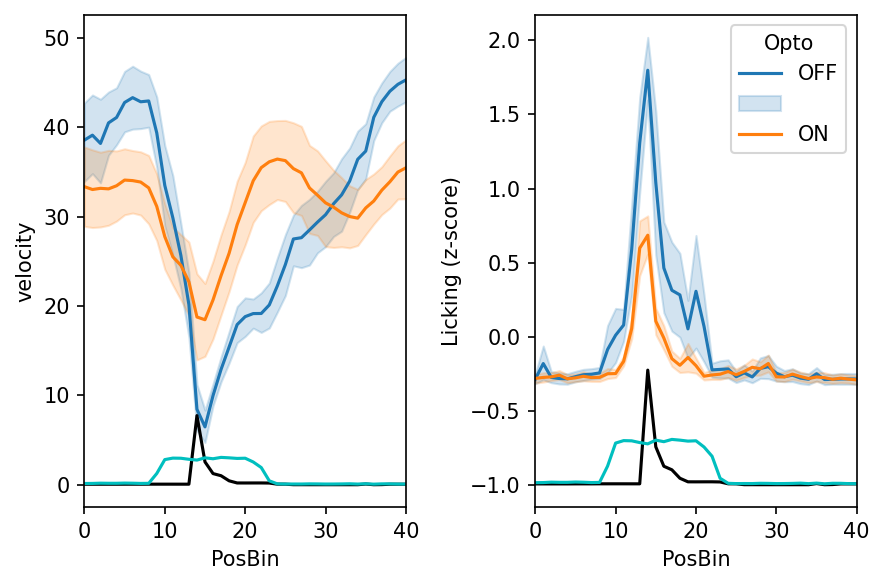

In [7]:
plt.ion()
fig, axs = plt.subplots(1,2, sharex=True)
sns.lineplot(data=posbinned.loc[posbinned.Group=='ChR'], x='PosBin', y='velocity', hue='optotrigger_lapwise', ax=axs[0], legend=None, ci=68)#, estimator=None, units='Experiment')
axs[0].plot(posbinned.groupby('PosBin').mean()['pump']*10, color='k')
axs[0].plot(posbinned.groupby('PosBin').mean()['optotrigger']*10, color='c')
axs[0].set_xlim([0, 40])
sns.lineplot(data=posbinned.loc[posbinned.Group=='ChR'], x='PosBin', y='LickingEnvFilt', hue='optotrigger_lapwise', ax=axs[1], legend=None, ci=68)
axs[1].set_xlim([0, 40])
axs[1].plot((posbinned.groupby('PosBin').mean()['pump']-1), color='k')
axs[1].plot((posbinned.groupby('PosBin').mean()['optotrigger']-1), color='c')
axs[1].legend(title='Opto', loc='upper right', labels=['OFF', '', 'ON'])
axs[1].set_ylabel('Licking (z-score)')
fig.tight_layout()

# plt.savefig('/Users/Oliver/Google Drive/AG Remy/Petra/VTAtoMSDBopto/optorew_zone1_traces.pdf')

In [20]:
off_pre = posbinned.loc[(posbinned.Group=='ChR')&(posbinned.PosBin<10)&(posbinned.PosBin>5)&(posbinned.optotrigger_lapwise==0)].groupby('Mouse').mean()[['velocity', 'LickingEnvFilt']]
off_pre['Opto'] = 0
off_pre['prepost'] = 'pre'

off_post = posbinned.loc[(posbinned.Group=='ChR')&(posbinned.PosBin<16)&(posbinned.PosBin>13)&(posbinned.optotrigger_lapwise==0)].groupby('Mouse').mean()[['velocity', 'LickingEnvFilt']]
off_post['Opto'] = 0
off_post['prepost'] = 'post'

on_pre = posbinned.loc[(posbinned.Group=='ChR')&(posbinned.PosBin<10)&(posbinned.PosBin>5)&(posbinned.optotrigger_lapwise==1)].groupby('Mouse').mean()[['velocity', 'LickingEnvFilt']]
on_pre['Opto'] = 1
on_pre['prepost'] = 'pre'

on_post = posbinned.loc[(posbinned.Group=='ChR')&(posbinned.PosBin<16)&(posbinned.PosBin>13)&(posbinned.optotrigger_lapwise==1)].groupby('Mouse').mean()[['velocity', 'LickingEnvFilt']]
on_post['Opto'] = 1
on_post['prepost'] = 'post'

optorew = pd.concat([off_pre, off_post, on_pre, on_post]).reset_index()
optorew['prepost'] = optorew['prepost'].astype('category').cat.reorder_categories(['pre', 'post'])

optorew

,Mouse,velocity,LickingEnvFilt,Opto,prepost
0,212,38.816178,-0.005957,0,pre
1,220,47.040949,-0.246204,0,pre
2,221,39.664789,-0.359745,0,pre
3,222,41.301928,-0.200340,0,pre
4,224,45.836889,-0.248805,0,pre
5,212,13.899277,2.574474,0,post
6,220,4.456463,1.273568,0,post
7,221,3.251687,0.721235,0,post
8,222,5.417483,0.429653,0,post
9,224,7.934684,1.582344,0,post


## Velocity (Fig. S4D)

In [21]:
pg.rm_anova(data=optorew, dv='velocity', within=['Opto', 'prepost'], subject='Mouse')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Opto,4.329460,1,4,4.329460,0.078440,0.793310,0.793310,0.003081,1.0
1,prepost,3057.181018,1,4,3057.181018,24.696210,0.007654,0.007654,0.685750,1.0
2,Opto * prepost,584.603969,1,4,584.603969,19.885033,0.011167,0.011167,0.294425,1.0


Text(0.5, 1.0, 'Opto ON')

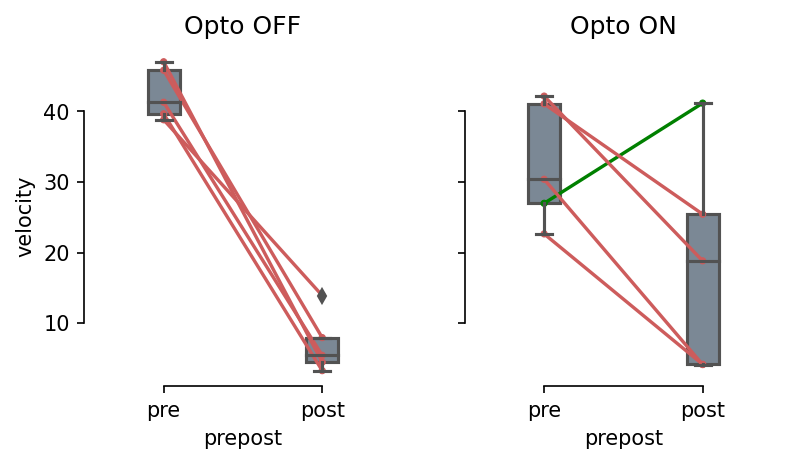

In [22]:
fig, axs = plt.subplots(1,2, figsize=(6,3), sharey=True)
pg.plot_paired(data=optorew.loc[optorew.Opto==0], dv='velocity', within='prepost', subject='Mouse', ax=axs[0], order=['pre', 'post'])
pg.plot_paired(data=optorew.loc[optorew.Opto==1], dv='velocity', within='prepost', subject='Mouse', ax=axs[1], order=['pre', 'post'])
axs[0].set_title('Opto OFF')
axs[1].set_title('Opto ON')
# plt.savefig('/Users/Oliver/Google Drive/AG Remy/Petra/VTAtoMSDBopto/optorew_stats_velocity.pdf')


In [23]:
pg.pairwise_tests(data=optorew, dv='velocity', within=['Opto', 'prepost'], subject='Mouse', padjust='bonf')

,Contrast,Opto,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Opto,-,0,1,True,True,-0.280071,4.0,two-sided,0.793310,NaN,NaN,0.411,-0.119748
1,prepost,-,post,pre,True,True,-4.969528,4.0,two-sided,0.007654,NaN,NaN,8.552,-2.740610
2,Opto * prepost,0,post,pre,True,True,-12.228527,4.0,two-sided,0.000257,0.000514,bonf,102.332,-8.079319
3,Opto * prepost,1,post,pre,True,True,-1.914350,4.0,two-sided,0.128102,0.256204,bonf,1.147,-0.995634


## Licking (Fig. S4C)

In [24]:
pg.rm_anova(data=optorew, dv='LickingEnvFilt', within=['Opto', 'prepost'], subject='Mouse')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Opto,1.095163,1,4,1.095163,3.836623,0.121732,0.121732,0.256566,1.0
1,prepost,6.094997,1,4,6.094997,73.442597,0.001018,0.001018,0.657613,1.0
2,Opto * prepost,0.900500,1,4,0.900500,3.880983,0.120167,0.120167,0.221043,1.0


Text(0.5, 1.0, 'Opto ON')

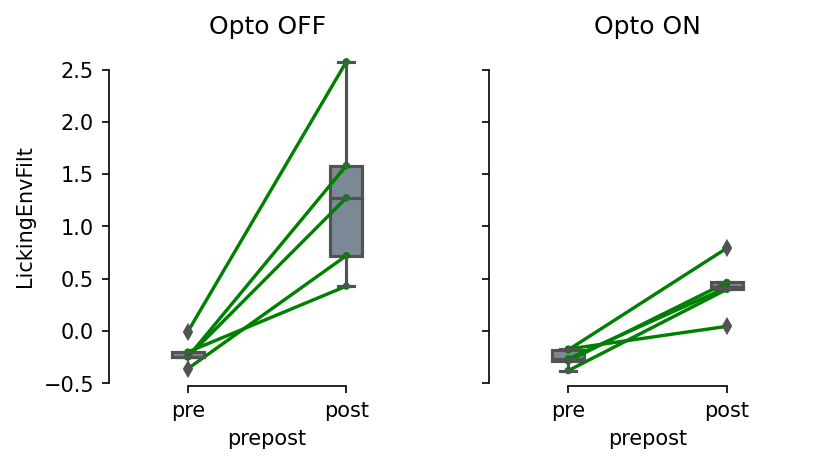

In [25]:
fig, axs = plt.subplots(1,2, figsize=(6,3), sharey=True)
pg.plot_paired(data=optorew.loc[optorew.Opto==0], dv='LickingEnvFilt', within='prepost', subject='Mouse', ax=axs[0], order=['pre', 'post'])
pg.plot_paired(data=optorew.loc[optorew.Opto==1], dv='LickingEnvFilt', within='prepost', subject='Mouse', ax=axs[1], order=['pre', 'post'])
axs[0].set_title('Opto OFF')
axs[1].set_title('Opto ON')
# plt.savefig('/Users/Oliver/Google Drive/AG Remy/Petra/VTAtoMSDBopto/optorew_stats_licking.pdf')

In [26]:
pg.pairwise_tests(data=optorew, dv='LickingEnvFilt', within=['Opto', 'prepost'], subject='Mouse', padjust='bonf')

,Contrast,Opto,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Opto,-,0,1,True,True,1.958730,4.0,two-sided,0.121732,NaN,NaN,1.188,1.222417
1,prepost,-,post,pre,True,True,8.569866,4.0,two-sided,0.001018,NaN,NaN,37.149,3.797342
2,Opto * prepost,0,post,pre,True,True,4.602413,4.0,two-sided,0.010013,0.020025,bonf,7.042,2.307819
3,Opto * prepost,1,post,pre,True,True,5.421746,4.0,two-sided,0.005611,0.011221,bonf,10.71,3.115824


In [27]:
lickatpump = posbinned.loc[(posbinned.Group=='ChR')&(posbinned.PosBin==14)].groupby(['Mouse', 'optotrigger_lapwise']).mean()['LickingEnvFilt'].reset_index()
lickatpump


,Mouse,optotrigger_lapwise,LickingEnvFilt
0,212,0.0,2.296691
1,212,1.0,0.103263
2,220,0.0,2.701804
3,220,1.0,0.952210
4,221,0.0,1.410975
5,221,1.0,1.122383
6,222,0.0,0.976840
7,222,1.0,0.912004
8,224,0.0,1.697332
9,224,1.0,0.521414


In [28]:
pg.rm_anova(data=lickatpump, dv='LickingEnvFilt', within='optotrigger_lapwise', subject='Mouse')

,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,optotrigger_lapwise,1,4,7.144833,0.055633,0.53811,1.0


## occupancy (Fig. S4E)

In [30]:
optolaps = data.groupby(['Experiment', 'Lap']).max()['optobout'].rename('optolaps')
data = data.join(optolaps, on=['Experiment', 'Lap'])
data

,sweep_index,position_raw,licking,pump,lfp,optotrigger,camtrigger_raw,sweep,camtrigger,optobout,...,onset_longloco_epoch,onset_longloco_noopto,onset_longloco_noopto_time,onset_longloco_noopto_epoch,opto_noloco,opto_noloco_time,opto_noloco_epoch,opto_freq_sharp,PosBin,optolaps
camframe,,,,,,,,,,,,,,,,,,,,,
0,15.5,1.431250,0.000000,-0.000937,0.027031,0.0,0.0,1.0,0.0,False,...,NaN,0,NaN,NaN,0,NaN,NaN,0.0,47,False
1,46.0,1.474063,0.000000,-0.000937,0.059375,0.0,0.0,1.0,0.0,False,...,NaN,0,NaN,NaN,0,NaN,NaN,0.0,47,False
2,75.0,1.498438,0.000625,-0.000937,0.002188,0.0,0.0,1.0,0.0,False,...,NaN,0,NaN,NaN,0,NaN,NaN,0.0,47,False
3,104.0,1.520625,0.001250,-0.000937,0.032500,0.0,0.0,1.0,0.0,False,...,NaN,0,NaN,NaN,0,NaN,NaN,0.0,47,False
4,133.0,1.566875,0.001563,-0.000937,0.058750,0.0,0.0,1.0,0.0,False,...,NaN,0,NaN,NaN,0,NaN,NaN,0.0,48,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39151,59884.5,-1.870000,0.000313,0.046562,0.200313,0.0,0.0,17.0,0.0,False,...,8.0,0,NaN,1.0,0,NaN,0.0,0.0,20,True
39152,59910.5,-1.865938,0.000469,0.046562,-0.075469,0.0,0.0,17.0,0.0,False,...,8.0,0,NaN,1.0,0,NaN,0.0,0.0,20,True
39153,59936.5,-1.861563,0.000625,0.046562,-0.041250,0.0,0.0,17.0,0.0,False,...,8.0,0,NaN,1.0,0,NaN,0.0,0.0,21,True


In [31]:
data['RewZone'] = False
data.loc[(data.position>70)&(data.position<130), 'RewZone'] = True
data

,sweep_index,position_raw,licking,pump,lfp,optotrigger,camtrigger_raw,sweep,camtrigger,optobout,...,onset_longloco_noopto,onset_longloco_noopto_time,onset_longloco_noopto_epoch,opto_noloco,opto_noloco_time,opto_noloco_epoch,opto_freq_sharp,PosBin,optolaps,RewZone
camframe,,,,,,,,,,,,,,,,,,,,,
0,15.5,1.431250,0.000000,-0.000937,0.027031,0.0,0.0,1.0,0.0,False,...,0,NaN,NaN,0,NaN,NaN,0.0,47,False,False
1,46.0,1.474063,0.000000,-0.000937,0.059375,0.0,0.0,1.0,0.0,False,...,0,NaN,NaN,0,NaN,NaN,0.0,47,False,False
2,75.0,1.498438,0.000625,-0.000937,0.002188,0.0,0.0,1.0,0.0,False,...,0,NaN,NaN,0,NaN,NaN,0.0,47,False,False
3,104.0,1.520625,0.001250,-0.000937,0.032500,0.0,0.0,1.0,0.0,False,...,0,NaN,NaN,0,NaN,NaN,0.0,47,False,False
4,133.0,1.566875,0.001563,-0.000937,0.058750,0.0,0.0,1.0,0.0,False,...,0,NaN,NaN,0,NaN,NaN,0.0,48,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39151,59884.5,-1.870000,0.000313,0.046562,0.200313,0.0,0.0,17.0,0.0,False,...,0,NaN,1.0,0,NaN,0.0,0.0,20,True,True
39152,59910.5,-1.865938,0.000469,0.046562,-0.075469,0.0,0.0,17.0,0.0,False,...,0,NaN,1.0,0,NaN,0.0,0.0,20,True,True
39153,59936.5,-1.861563,0.000625,0.046562,-0.041250,0.0,0.0,17.0,0.0,False,...,0,NaN,1.0,0,NaN,0.0,0.0,21,True,True


In [32]:
optorew_time = (data.loc[data.RewZone==True].groupby(['Group', 'Mouse', 'optolaps']).count()['pump'] / data.groupby(['Group', 'Mouse', 'optolaps']).count()['pump']).reset_index()
optorew_time

,Group,Mouse,optolaps,pump
0,ChR,212,False,0.376083
1,ChR,212,True,0.067574
2,ChR,220,False,0.247236
3,ChR,220,True,0.150546
4,ChR,221,False,0.469114
5,ChR,221,True,0.358765
6,ChR,222,False,0.626743
7,ChR,222,True,0.352066
8,ChR,224,False,0.456741
9,ChR,224,True,0.199904


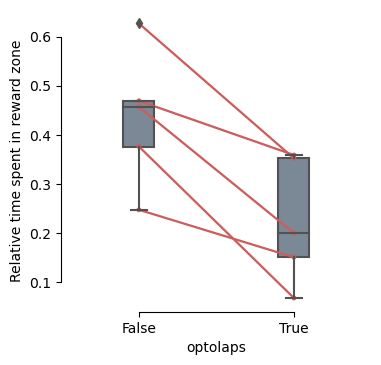

In [33]:
pg.plot_paired(data=optorew_time.loc[optorew_time.Group=='ChR'], dv='pump', within='optolaps', subject='Mouse')
plt.ylabel('Relative time spent in reward zone');
# plt.savefig('/Users/Oliver/Google Drive/AG Remy/Petra/VTAtoMSDBopto/optorew_stats_reltimereward.pdf')


In [34]:
pg.normality(optorew_time.pump)

,W,pval,normal
pump,0.982174,0.988376,True


In [35]:
pg.pairwise_tests(data=optorew_time.loc[optorew_time.Group=='ChR'], dv='pump', within='optolaps', subject='Mouse')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,optolaps,False,True,True,True,4.751493,4.0,two-sided,0.008961,7.63,1.41911


# only opto zone 2 (Fig. S4B)

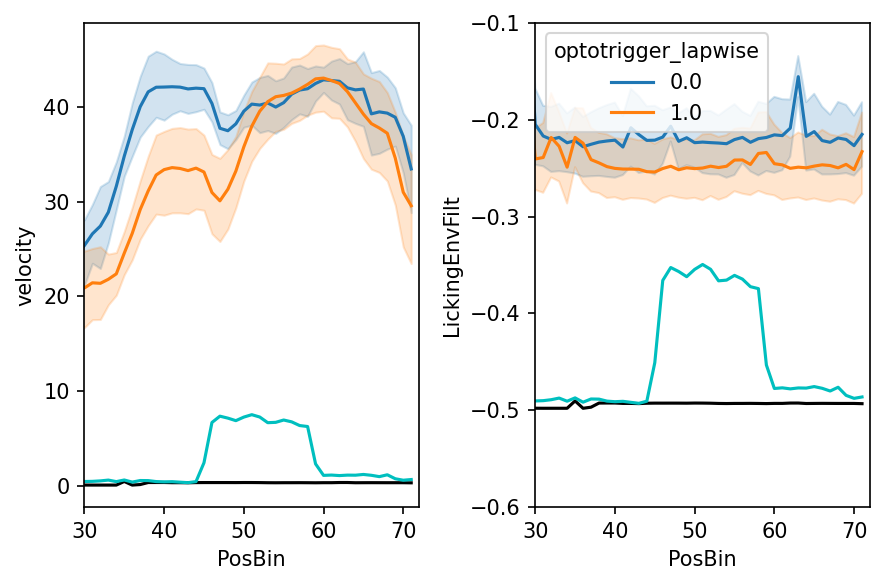

In [36]:
plt.ion()
fig, axs = plt.subplots(1,2, sharex=True)
sns.lineplot(data=posbinned.loc[(posbinned.Experiment.str.contains("2zones"))&(posbinned.Group=='ChR')], x='PosBin', y='velocity', hue='optotrigger_lapwise', ax=axs[0], legend=None, ci=68)
axs[0].set_xlim([30, 72])
axs[0].plot(posbinned.groupby('PosBin').mean()['pump']*50, color='k')
axs[0].plot(posbinned.groupby('PosBin').mean()['optotrigger']*50, color='c')
sns.lineplot(data=posbinned.loc[(posbinned.Experiment.str.contains("2zones"))&(posbinned.Group=='ChR')], x='PosBin', y='LickingEnvFilt', hue='optotrigger_lapwise', ax=axs[1], ci=68)#, estimator=None, units='Experiment')
axs[1].plot((posbinned.groupby('PosBin').mean()['pump']-.5), color='k')
axs[1].plot((posbinned.groupby('PosBin').mean()['optotrigger']-.5), color='c')
axs[1].set_xlim([30, 72])
axs[1].set_ylim([-.6, -.1])
fig.tight_layout()

# plt.savefig('/Users/Oliver/Google Drive/AG Remy/Petra/VTAtoMSDBopto/optorew_zone2_traces.pdf')


In [37]:
off_pre = posbinned.loc[(posbinned.Group=='ChR')&(posbinned.PosBin<45)&(posbinned.PosBin>35)&(posbinned.optotrigger_lapwise==0)].groupby('Mouse').mean()[['velocity', 'LickingEnvFilt']]
off_pre['Opto'] = 0
off_pre['prepost'] = 'pre'

off_post = posbinned.loc[(posbinned.Group=='ChR')&(posbinned.PosBin<65)&(posbinned.PosBin>55)&(posbinned.optotrigger_lapwise==0)].groupby('Mouse').mean()[['velocity', 'LickingEnvFilt']]
off_post['Opto'] = 0
off_post['prepost'] = 'post'

on_pre = posbinned.loc[(posbinned.Group=='ChR')&(posbinned.PosBin<45)&(posbinned.PosBin>35)&(posbinned.optotrigger_lapwise==1)].groupby('Mouse').mean()[['velocity', 'LickingEnvFilt']]
on_pre['Opto'] = 1
on_pre['prepost'] = 'pre'

on_post = posbinned.loc[(posbinned.Group=='ChR')&(posbinned.PosBin<65)&(posbinned.PosBin>55)&(posbinned.optotrigger_lapwise==1)].groupby('Mouse').mean()[['velocity', 'LickingEnvFilt']]
on_post['Opto'] = 1
on_post['prepost'] = 'post'

optorew = pd.concat([off_pre, off_post, on_pre, on_post]).reset_index()
optorew['prepost'] = optorew['prepost'].astype('category').cat.reorder_categories(['pre', 'post'])

# optorew

## Velocity (Fig. S4G)

In [38]:
pg.rm_anova(data=optorew, dv='velocity', within=['Opto', 'prepost'], subject='Mouse')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Opto,83.456009,1,4,83.456009,2.450729,0.192526,0.192526,0.117153,1.0
1,prepost,43.208517,1,4,43.208517,0.902205,0.395977,0.395977,0.064287,1.0
2,Opto * prepost,32.962170,1,4,32.962170,11.595867,0.027145,0.027145,0.049801,1.0


Text(0.5, 1.0, 'Opto ON')

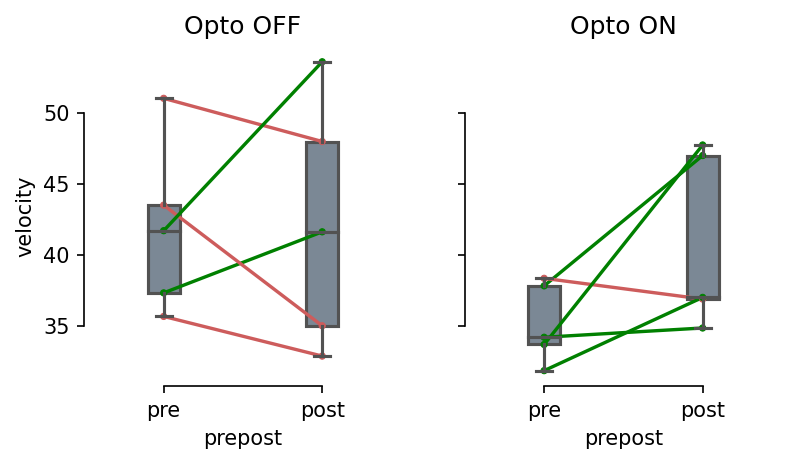

In [39]:
# sns.barplot(data=optorew, x='Opto', hue='prepost', ci=68, y='velocity')
fig, axs = plt.subplots(1,2, figsize=(6,3), sharey=True)
pg.plot_paired(data=optorew.loc[optorew.Opto==0], dv='velocity', within='prepost', subject='Mouse', ax=axs[0], order=['pre', 'post'])
pg.plot_paired(data=optorew.loc[optorew.Opto==1], dv='velocity', within='prepost', subject='Mouse', ax=axs[1], order=['pre', 'post'])
axs[0].set_title('Opto OFF')
axs[1].set_title('Opto ON')
# plt.savefig('/Users/Oliver/Google Drive/AG Remy/Petra/VTAtoMSDBopto/optorew_stats_velocity_onlyopto.pdf')


In [40]:
pg.pairwise_tests(data=optorew, dv='velocity', within=['Opto', 'prepost'], subject='Mouse', padjust='bonf')

,Contrast,Opto,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Opto,-,0,1,True,True,1.565480,4.0,two-sided,0.192526,NaN,NaN,0.872,0.715171
1,prepost,-,post,pre,True,True,0.949845,4.0,two-sided,0.395977,NaN,NaN,0.558,0.484102
2,Opto * prepost,0,post,pre,True,True,0.105727,4.0,two-sided,0.920889,1.000000,bonf,0.399,0.044981
3,Opto * prepost,1,post,pre,True,True,1.958514,4.0,two-sided,0.121762,0.243524,bonf,1.188,1.042117


## Licking (Fig. S4F)

In [41]:
pg.rm_anova(data=optorew, dv='LickingEnvFilt', within=['Opto', 'prepost'], subject='Mouse')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Opto,0.000046,1,4,0.000046,0.147560,0.720425,0.720425,0.000572,1.0
1,prepost,0.000045,1,4,0.000045,0.226944,0.658654,0.658654,0.000560,1.0
2,Opto * prepost,0.000012,1,4,0.000012,0.088214,0.781245,0.781245,0.000148,1.0


Text(0.5, 1.0, 'Opto ON')

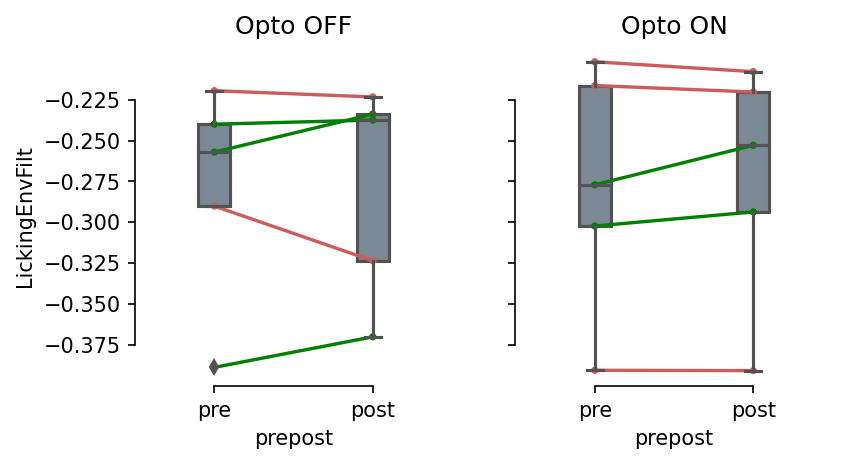

In [42]:
# sns.barplot(data=optorew, x='Opto', hue='prepost', ci=68, y='velocity')
fig, axs = plt.subplots(1,2, figsize=(6,3), sharey=True)
pg.plot_paired(data=optorew.loc[optorew.Opto==0], dv='LickingEnvFilt', within='prepost', subject='Mouse', ax=axs[0], order=['pre', 'post'])
pg.plot_paired(data=optorew.loc[optorew.Opto==1], dv='LickingEnvFilt', within='prepost', subject='Mouse', ax=axs[1], order=['pre', 'post'])
axs[0].set_title('Opto OFF')
axs[1].set_title('Opto ON')
# plt.savefig('/Users/Oliver/Google Drive/AG Remy/Petra/VTAtoMSDBopto/optorew_stats_licking_onlyopto.pdf')


In [43]:
pg.pairwise_tests(data=optorew, dv='LickingEnvFilt', within=['Opto', 'prepost'], subject='Mouse', padjust='bonf')

,Contrast,Opto,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Opto,-,0,1,True,True,-0.384135,4.0,two-sided,0.720425,NaN,NaN,0.422,-0.038977
1,prepost,-,post,pre,True,True,0.476386,4.0,two-sided,0.658654,NaN,NaN,0.436,0.038670
2,Opto * prepost,0,post,pre,True,True,0.144063,4.0,two-sided,0.892417,1.000000,bonf,0.401,0.019836
3,Opto * prepost,1,post,pre,True,True,0.817926,4.0,two-sided,0.459322,0.918644,bonf,0.515,0.054645
